Names of Students and ID: Fritz Darchinger 813336    
Group number: Group F    

# Clustering of genomic sequences with Mixture Models


The goal of the project is to implement a mixture model that can cluster genomic sequences. 
This jupyter notebook will serve as a guide for the different steps of the implementation of the model and of its estimation. The last part is an application to a dataset from the Ebola epidemics.

### For grading, you are just expected to fill in this notebook. However the accompanying project sheet contains complementary information and it is recommended to study it before.

## Representative sequences 

Sequences will be encoded as vectors of integers with values between 0 (A) and 3 (T). 

We will first code functions to estimate a representative from a set of sequences and to compute the probability of a sequence given a representative and an error rate.


In [2]:
import numpy as np 

##Constants
nDNA = 4

c1 = np.array([0,1,3,1,3]) #c1 is the sequence ACTAT
c2 = np.array([1,1,1,0,3]) #c2 is the sequence CCCAG
#(s1,s2,s3) = (ACACA, ACTAT, CCTAG)
s = np.array([[0,1,0,1,0], [0,1,3,1,3], [1,1,3,0,2]]) 

print(c1, c2)

print(s)


[0 1 3 1 3] [1 1 1 0 3]
[[0 1 0 1 0]
 [0 1 3 1 3]
 [1 1 3 0 2]]


## Simulating sequences

### Write a functions to simulate a set of sequences from a cluster.

This function will take as input a representative `c` the error rate `mu` and `n` the number of sequences
to generate and return a numpy array of dimension `(n, len(c))`.


In [3]:
def simulate_seqs(n: int, c: np.ndarray[int], mu: float) -> np.ndarray[int, int]:
    """
    int * ndarray[int] * float -> ndarray[int,int]
    """
    seqs = np.tile(c, (n,1))
    #your code here
    modifier = np.random.choice([0,1,2,3], size=seqs.shape, p=(1-mu,mu/3,mu/3,mu/3))
    return (seqs + modifier) % 4

##Simulate 100 sequences with mu=0.1 and verify that the average percentage
##of mutation is indeed 10% (in other words we expect on average a mutation every ten positions)

n1 = 1000000
mu1 = 0.1
ssim = simulate_seqs(n1, c1, mu1)

#your code here
mu1_sim = np.count_nonzero(ssim - c1) / len(c1) / n1
print(f"theoretical mutation rate: {mu1}, simulated mutation rate {mu1_sim}")

theoretical mutation rate: 0.1, simulated mutation rate 0.10006


## Computing sequence probabilities

### 1. Write a function that computes the log probability for a set of sequences

It will take as input a matrix of sequences, the representative, and the  error rate `mu`


In [4]:
def LogProbabilities(s: np.ndarray[int, int], c: np.ndarray[int], mu: float) -> np.ndarray[float]:
    """
    ndarray[int,int] * ndarray[int] * float -> ndarray[float]
    """
    ## Your code here
    mutations = np.count_nonzero(s - c, axis=1)
    return np.log(mu / 3) * mutations + np.log(1-mu) * (s.shape[1]-mutations)
    

print(LogProbabilities(s, c1, 0.09))
print("expected result:", np.log([0.91**3*0.03**2, 0.91**5, 0.91**2 * 0.03**3]))
print(LogProbabilities(s, c2, 0.09))

[ -7.29604783  -0.4715534  -10.70829505]
expected result: [ -7.29604783  -0.4715534  -10.70829505]
[-14.12054227 -10.70829505  -7.29604783]


### 2. Compute the class posteriors 

This function takes as argument a set of representatives, a set of error rate and the class priors and returns a 
matrix of all the class posterior. You can use the function `LogProbabilities` to simplify the computation.


In [5]:
def ClassPosterior(s: np.ndarray[int, int], list_c: np.ndarray[int,int], list_mu: np.ndarray[float], 
                   priors: np.ndarray[float]) -> np.ndarray[float, float]:
    """
    ndarray[int, int] * ndarray[int] * ndarray[float] * ndarray[float] -> ndarray[float, float]
    """
    ### Your code here
    logprobs = np.vectorize(lambda i: LogProbabilities(s, list_c[i], list_mu[i]), signature='()->(n)')(range(len(list_c)))
    probs = np.exp(logprobs.T) * priors
    probsums = np.vstack(probs.sum(1))
    return probs / np.where(probsums==0, 1, probsums)


mus = np.array([0.09, 0.09])
pi = np.array([0.5, 0.5])
posteriors = ClassPosterior(s, np.array([c1, c2]), mus, pi)

print(posteriors)
##Expected output
#[[9.98914355e-01 1.08564536e-03]
# [9.99964172e-01 3.58281206e-05]
# [3.19148936e-02 9.68085106e-01]]

[[9.98914355e-01 1.08564536e-03]
 [9.99964172e-01 3.58281206e-05]
 [3.19148936e-02 9.68085106e-01]]


### 3. Compute the loglikelihood of the sequences

Compute the conditional loglikelihood of the sequences by integrating over all possible class membership (note that you will have to compute an exponential of the logprobabilities computed with the previous function.
$$
\log P(s_1,\ldots, s_n \mid (c_1, \ldots, c_K), (\mu_1, \ldots, \mu_K), (\pi_1,\ldots, \pi_K)) = 
\sum_{i=1}^n \log \Big(\sum_{i=1}^K \pi_k P(s_i \mid z_i = k)\Big)
$$
(note: $z_i$ is the class of the sequence $s_i$)

In [6]:
def conditional_loglikelihood(s: np.ndarray[int, int], list_c: np.ndarray[int, int], 
                              list_mu: np.ndarray[float], priors: np.ndarray[float]) -> float:
    """
    ndarray[int, int] * ndarray[int] * ndarray[float] * ndarray[float] -> float
    """
    ##Your code here
    logprobs = np.vectorize(lambda i: LogProbabilities(s, list_c[i], list_mu[i]), signature='()->(n)')(range(len(list_c)))
    innersum = np.sum(priors * np.exp(logprobs.T), 1)
    return np.sum(np.where(innersum == 0, 0, np.log(innersum)))

print(conditional_loglikelihood(s, np.array([c1, c2]), mus, pi))

-17.109533265532214


## Estimating class representatives and implementing EM _light_

In the following we will implement a simplified version of EM with binary class allocations (each sequence is in the class where it has the highest posterior probability).

We will first write a function to update class representative and error rate from a set of sequences and then
implement EM


### 1. Write two functions, one to estimate the sequence representative and one to estimate the error rate

From set of sequences, we compute first the profile of the sequences at each position and as consensus the most
represented nucleotide. We then estimate the error rate by counting the number of differences to the consensus.



In [7]:
from typing import Optional
def estimate_representative(s: np.ndarray[int, int]) -> Optional[np.ndarray[int]]:
    """
    ndarray[int, int] -> ndarray[int]    
    from a n * L matrix of sequences, returns the consensus sequence 
    """
    return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), 0, s) if s.shape[0] != 0 else None
    
def estimate_error_rate(s: np.ndarray[int, int], c: np.ndarray[int, int]) -> float:
    """
    ndarray[int, int] -> float
    """
    return (np.count_nonzero(s - c) or 1) / s.shape[1] / s.shape[0] # note: applied 'smoothing' because we know mu != 0

c = estimate_representative(s)
mu = estimate_error_rate(s, c)
print(c) # [0 1 3 1 0]
print(mu) # 0.3333333333333333
    

[0 1 3 1 0]
0.3333333333333333


### 2. Implementing EM

We will implement the EM algorithm with fixed class allocation:    

0. fix the number of clusters $K$
1. Initialise random allocation of the representative. The most common way is to sample the $K$ representative from the set of points **(do not initialize with random sequences!)**. 
2. Until convergence
    - Compute the class posteriors for each sequence
    - Allocate each sequence to the most probable class
    - Update cluster representative and error rate

Note that this algorithm works in the spirit of the K-means algorithm in the sense that the class allocations are fixed at each step. However, an adapation of K-means to multinoulli would only estimate class centers. Here we estimate class centers $c_k$ and the error rate $\mu_k$ for each class.

If the algorithm does not converge well, you can inspire yourself from the kmean++ algorithm for initialisation. 

For the convergence criterion we can monitor the class representatives and stop when they do not change anymore.

The function will return a matrix (K x L) of the class representatives, a vector of the class proportions and optionally a vector of the likelihoods at each iteration.



In [ ]:
def EM(s: np.ndarray[int, int], K: int, threshold: float = 1e-4, max_iter: int = 1000
       ) -> tuple[np.ndarray[int,int], np.ndarray[float], np.ndarray[float]]:
    """
    ndarray[int,int] * int -> (ndarray[int, int], ndarray[float], ndarray[float])
    """
    # note: k-means++ initialisation with a distance matrix
    c = np.tile(0, (K, s.shape[1]))
    c[0] = s[np.random.choice(s.shape[0], 1)]
    distances = np.tile(0.0, (K, s.shape[0]))
    distances[0] = np.linalg.norm(s-c[0], axis=1) # note: forgot the square the distances (oops)
    for i in range(1, K):
        weights = distances[:i].min(0)
        c[i] = s[np.random.choice(s.shape[0], 1, p=weights/weights.sum())]
        distances[i] = np.linalg.norm(s-c[i], axis=1)

    mu = np.tile(0.1, K) # note: could have calculated for classes from rep but figured 1st iteration of EM does that anyways
    pi = np.tile(1 / K, K) # note: as above
    condlikes = [conditional_loglikelihood(s, c, mu, pi)]

    for _ in range(max_iter):
        posteriors = ClassPosterior(s, c, mu, pi)

        seqs_per_class = [[] for _ in range(K)]
        for i,v in enumerate(np.argmax(posteriors, axis=1)): # group sequences by class
            seqs_per_class[v] += [i]

        c_u, mu_u, pi_u = np.empty_like(c), np.empty_like(mu), np.empty_like(pi)
        for k in range(K):
            if seqs_per_class[k]:
                s_k = s[seqs_per_class[k]]
                c_u[k] = estimate_representative(s_k)
                mu_u[k] = estimate_error_rate(s_k, c[k])
                pi_u[k] = len(s_k) / len(s)
            else: # empty class ! -> some arbitrary values, pi = 0
                c_u[k] = np.zeros_like(c[k])
                mu_u[k] = np.tile(0.5, mu[k].shape)     # note: i assume empty classes -> extraneous classes, this speeds up runtime significantly
                pi_u[k] = 0

        condlike_u = conditional_loglikelihood(s, c_u, mu_u, pi_u)
        c, mu, pi = c_u, mu_u, pi_u
        if abs(condlike_u - condlikes[-1]) < threshold: # note: stop condition via conditional likelihood, threshold is actually never relevant (changes 0 or >20)
            break

        condlikes.append(condlike_u)
    return c, mu, pi, np.array(condlikes)


### 3. Validating on simulated data


The file `simul_3_clusters.csv` contains a simulation of 400 sequences of length 100 sampled from 3 clusters with proportions $\pi = (0.6, 0.3, 0.1) $. 
- Apply EM on the simulated sequences 
- Verify that the estimation of the clusters worked correctly by checking the estimated class representative and the prior (file `simul_representatives.csv`)
- Verify the class allocations as well (file `simul_sequences_class.csv`)
- What are the error rates $(\mu_1, \mu_2, \mu_3)$ for each of the classes?

**Note: be careful while loading the file `simul_representatives.csv`, it has no header**

### 4. Determining the number of clusters

Run EM for $K$ ranging from 2 to 10 and record the loglikelihood for each adjusted model adjusted.
Plot the value of the loglikelihood against $K$, what do you observe?


In [9]:
s_simul = np.loadtxt("simul_3_clusters.csv", delimiter=",", dtype="int")
c_simul = np.loadtxt("simul_representatives.csv", delimiter=",", dtype="int")
seq_simul = np.loadtxt("simul_sequences_class.csv", delimiter=",", dtype="int")

In [10]:
c, mu, pi, loglikes = EM(s_simul, 3)
for i in range(0, 50): # noise insulation
    print("-", end="")
    c_i, mu_i, pi_i, loglikes_i = EM(s_simul, 3)
    if loglikes_i[-1] > loglikes[-1]:
        c, mu, pi, loglikes = c_i, mu_i, pi_i, loglikes_i
print("|")
print(pi, mu, loglikes[-1])

--------------------------------------------------|
[0.0675 0.6175 0.315 ] [0.01777778 0.10121457 0.05174603] -14754.90281681751


In [12]:
# note: i should have compared classes by representatives but i figured this was enough
print(f"Representatives off by {np.apply_along_axis(lambda ci: np.linalg.norm(c_simul - ci, axis=1).min(), 1, c)}")
print(f"Priors off by {np.unique(seq_simul, return_counts=True)[1] / len(seq_simul) + sorted(-pi)}")
allocations = np.argmax(ClassPosterior(s_simul, c, mu, pi), axis=1)
misallocations = (np.unique(allocations, return_counts=True)[1] - np.unique(seq_simul, return_counts=True)[1]).sum()
print(f"Mismatched class allocations: {misallocations}/{len(allocations)}")
print(f"Error rates: {mu}")

Representatives off by [0. 0. 0.]
Priors off by [0. 0. 0.]
Mismatched class allocations: 0/400
Error rates: [0.01777778 0.10121457 0.05174603]


k = 2: [-15677.6494525  -15677.6494525  -15677.6494525  -19458.85693108
 -15677.6494525  -15677.6494525  -15677.6494525  -15677.6494525
 -19483.99456642 -19469.18027328 -15677.6494525  -15677.6494525
 -15677.6494525  -15677.6494525  -15677.6494525  -15677.6494525
 -19458.85693108 -15677.6494525  -19483.99456642 -19483.99456642
 -15677.6494525  -15677.6494525  -15677.6494525  -15677.6494525
 -19483.99456642 -15677.6494525  -19483.99456642 -15677.6494525
 -19483.99456642 -15677.6494525  -19483.99456642 -19483.99456642
 -19483.99456642 -15677.6494525  -15677.6494525  -19483.99456642
 -15677.6494525  -15677.6494525  -15677.6494525  -15677.6494525
 -19432.72466573 -15677.6494525  -15677.6494525  -15677.6494525
 -19483.99456642 -15677.6494525  -19483.99456642 -15677.6494525
 -15677.6494525  -19483.99456642]
k = 3: [-15628.69085978 -14754.90281682 -15677.6494525  -14754.90281682
 -15625.42126966 -15677.6494525  -15615.6100999  -15628.69085978
 -15649.43872234 -19403.34433472 -15677.6494525  -

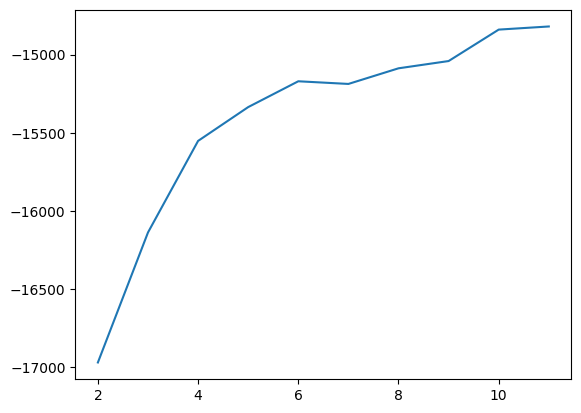

In [16]:
import matplotlib.pyplot as plt
## Write the code here to check the number of clusters.
numreps = 50
numk = 10
loglikelihoods = np.tile(0.0, (numk,numreps))
for k in range(2, 2+numk):
    print(f"k = {k}: ", end="")
    for i in range(0, numreps):
        c_k, mu_k, pi_k, loglikes_k = EM(s_simul, k)
        loglikelihoods[k-2][i] = loglikes_k[-1]
    print(loglikelihoods[k-2])

plt.plot(range(2, 2+numk), loglikelihoods.mean(1))
plt.show()
# increasing the number of clusters seems to asymptotically increase the 
# average fit as the initialization becomes better
# after all, extraneous representatives just get eliminated
# note: this is partially inaccurate; the fit also just becomes better
# note: elbow rule here would recommend k = ~6 which is twice the true value

## Application to real data: Ebola

We gonna apply our clustering method to real sequences from the Ebola epidemics in west Africa in 2014-2016. 
We will first start with a simple "detective work" on a set of simple sequences to understand the questions related to outbreak analysis.  

**!!! This part is more difficult to complete, do not hesitate to reach out for guidance on the data analysis and on the initialisation of the EM parameters!!!**


### 1. Detective training

This part is condensed from an activity proposed on the excellent [HHMI biointeractive website](https://www.biointeractive.org/classroom-resources/ebola-disease-detectives). It is recommended start by reading this [short summary on the Ebola epidemics](https://www.biointeractive.org/sites/default/files/Introduction-to-Ebola.pdf). 

Below is a set of DNA sequences that includes the reference sample from Guinea and 15 Ebola DNA sequences from samples of patients in Sierra Leone. We will reason on those sequences to understand better how genomic information can help understanding the spread of a virus. 


- The shaded nucleotides in sequences 1–15 represent mutations that occurred in these different viruses compared to the reference sequence. (Remember that the reference sequence is from a virus that was present at the start of the outbreak.) 
- Move the Ebola sequences 1–15 around to identify patterns in the mutations.
- Group sequences according to any patterns you see.
- Every sequence should be in a group, even if they are not identical. Use your groupings to answer the analysis questions.

<div>
<img src="ebola_sequences.png" width="400"/>
</div>



#### 1.a Write your groups below



Group 1: Sequences 2, 5, 7, 8, 10, 12, 15.    
Group 2: Sequences 1, 3, 4, 6, 9, 11, 13, 14.    

#### 1.b What was your criteria to construct this grouping? Could you have used an alternative criteria?

My criterion was to group viral dna by strain - a successful strain is indicated by a large number of sequences with almost identical mutations. All sequences possess an identical mutation in the 2nd and 6th nucleotides, but members of group 2 also possess an identical mutation in the 1st, 7th, 12th and 13th nucleotide. No other pattern is directly apparent, the rest of the mutations seem to be noise.    

Sequences 8 and 12 are identical, sequences 10 and 1 have particulary significant additional mutations, so they could all be given individual groups.

#### 1.c If a sequence has a larger number of mutations when compared to the reference sequence, does that mean it is from earlier or later in the outbreak? Explain your answer. 

On average, it means it is from later in the outbreak, as mutations happen randomly over time and therefore the amount of mutations tends to trend up.

#### 1.d Create a visual that highlights the relationship between your groups. Examples of effective visuals include flowcharts and trees. Be sure that your visual includes an arrow indicating passage of time during the outbreak. 


<div>
<img src="ebola_sequences_done.png"/>
</div>

### 2. Testing the clustering algorithm

Let's apply our clustering algorithm to a set of sequences from the 2014-2016 epidemics. We started from the genome data available on [this website](https://github.com/ebov/space-time) listing 1610 sequences during the pandemics. We selected a subset of sequences and recorded only positions that are changing. We also prepared the data as a numpy array. 

#### 2.a Run the mixture model for different values of $k$ 

#### 2.b Determine the most suited value for $k$. What about the resulting groups, are they very diverse?

k = 10: 

C:\Users\Fritz\AppData\Local\Temp\ipykernel_24908\2943558313.py:11: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(innersum == 0, 0, np.log(innersum)))


[-13188.44548338 -12384.63124044 -12430.65218655 -12236.10663457
 -11165.12647062 -12589.96875956 -14946.7350012  -11855.85065359
 -13340.50872135 -12364.88167174]
k = 11: [-11824.51080844 -13630.14212021 -11623.21337528 -11792.1211675
 -11874.0946218  -12059.97489617 -12152.81246907 -12102.39137268
 -11143.55272871 -11023.29968393]
k = 12: [-11715.14416803 -13465.32904631 -11822.32657742 -10805.18507761
 -11240.82742509 -11568.41341958 -11524.90807584 -11764.40808752
 -11028.73365899 -10963.39007949]
k = 13: [-10080.03438675 -12227.67646305 -10429.57533632 -10960.82996775
 -10502.96840546 -11409.03443412 -11339.06178238 -11097.61468306
 -11892.52067651 -10914.98527475]
k = 14: [-10464.98038367 -10232.37456404 -11143.27276773  -9847.21273535
 -10092.20818886 -11181.8387387  -10790.40086969 -10130.29331657
 -10379.78434988 -11277.14865791]
k = 15: [-11099.93513482 -11055.19118703 -10985.48391153  -9616.0331166
 -10679.84328878  -9921.27575873 -10668.55538136  -9571.67382244
 -10144.4208

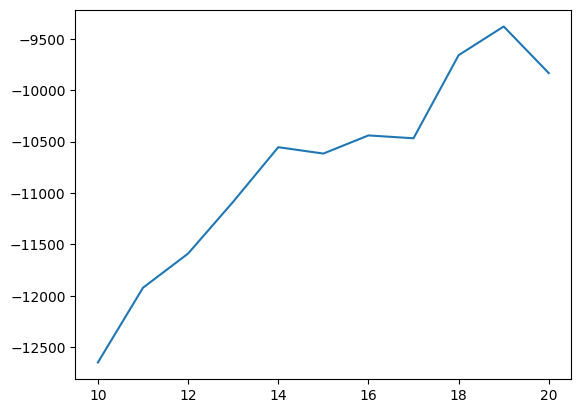

Best k: 19 with loglikelihood of -9378.452220699572


In [ ]:
# Loading data
import pickle as pkl
sequences = pkl.load(open('Ebola_data/ebola.pkl', 'rb'))

# Running EM with different values for k
kstep = 1
kmin, kmax = 10, 20
assert (kmax-kmin) % kstep == 0
instances = 10

best_k = 0
best_loglikelihood = float("-inf")

loglikelihoods = np.tile(0.0, (int((kmax-kmin)/kstep)+1, instances))
for k in range(kmin, kmax+1, kstep):
    print(f"k = {k}: ", end="")
    for i in range(0, instances):
        c_k, mu_k, pi_k, loglikes_k = EM(sequences, k)
        loglikelihoods[int((k-kmin)/kstep)][i] = loglikes_k[-1]
    print(loglikelihoods[int((k-kmin)/kstep)])
    if loglikelihoods[int((k-kmin)/kstep)].mean() > best_loglikelihood:
        best_loglikelihood = loglikelihoods[int((k-kmin)/kstep)].mean()
        best_k = k

plt.plot(range(kmin, kmax+1, kstep), loglikelihoods.mean(1))
plt.show()

# considering the graph, there is an elbow at around k = 14
# this then seems to be a reasonable amount of clusters
# not sure how to measure diversity but given the dataset
# we expect an average of ~10 unique samples per cluster
# which is diverse enough

k = 5: 

C:\Users\Fritz\AppData\Local\Temp\ipykernel_24908\2943558313.py:11: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.where(innersum == 0, 0, np.log(innersum)))


[-15169.76876116 -15185.00173875 -15058.63860788]
k = 15: [ -9965.26494371 -11059.62865599 -10083.29104142]
k = 25: [-8681.81368359 -8109.47490106 -9521.87275766]
k = 35: [-7941.59339575 -7348.4255258  -6905.32347485]
k = 45: [-6093.88678623 -5248.79880513 -6033.97916678]
k = 55: [-4689.55070535 -3476.2653938  -3964.42687191]
k = 65: [-3877.41512762 -3601.82737363 -4071.84597244]
k = 75: [-3204.82871265 -3091.28846062 -3117.97313134]
k = 85: [-3280.35716126 -2830.76635628 -2680.86434058]
k = 95: [-2398.95304282 -2842.07597453 -2543.43049217]
k = 105: [-2356.49728937 -2296.22204651 -2319.02581399]
k = 115: [-2540.81235672 -2351.6875278  -2293.55727348]
k = 125: [-2235.0772621  -2158.21534238 -2141.92489621]
k = 135: [-2094.49114938 -2098.01865752 -2093.06071382]
k = 145: [-2037.86827441 -2037.86827441 -2037.86827441]


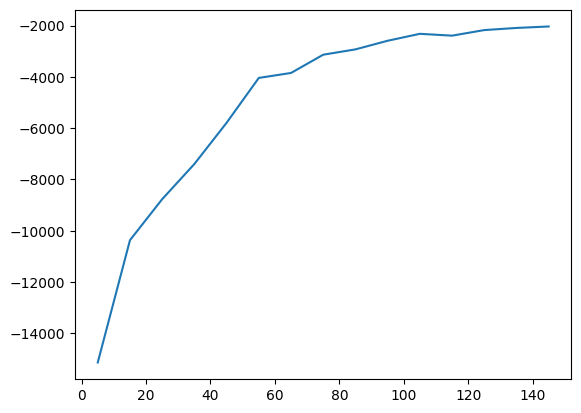

Best k: 145 with loglikelihood of -2037.8682744082344


In [31]:
# i thought this was interesting, this is from before switching to the elbow estimation above
kstep = 10
kmin, kmax = 5, 145
assert (kmax-kmin) % kstep == 0
instances = 3

best_k = 0
best_loglikelihood = float("-inf")

loglikelihoods = np.tile(0.0, (int((kmax-kmin)/kstep)+1, instances))
for k in range(kmin, kmax+1, kstep):
    print(f"k = {k}: ", end="")
    for i in range(0, instances):
        c_k, mu_k, pi_k, loglikes_k = EM(sequences, k)
        loglikelihoods[int((k-kmin)/kstep)][i] = loglikes_k[-1]
    print(loglikelihoods[int((k-kmin)/kstep)])
    if loglikelihoods[int((k-kmin)/kstep)].mean() > best_loglikelihood:
        best_loglikelihood = loglikelihoods[int((k-kmin)/kstep)].mean()
        best_k = k

plt.plot(range(kmin, kmax+1, kstep), loglikelihoods.mean(1))
plt.show()

# Determine the most suited value for k
print(f"Best k: {best_k} with loglikelihood of {best_loglikelihood}")
# this always seems to be the highest number 
# k=145 is max because there are exactly 145 unique sequences...
# am I missing some sort of term punishing k?
# anyways, the groups are not particularly diverse
# because each group is just copies of the representation

#### 2.c Do you see limitations in applying the clustering algorithm to an outbreak? What are the advantages? What would be an alternative method?

It seems that the number of clusters has to be known a-priori somehow? I'm not sure.    
Certainly it is difficult to tell what exact k is appropriate.    
Since mutations happen over time some sort of markov model may be better able to model sequences...    